Welcome to my notebook! This is a copy/paste welcome message for all my notebooks :) 📓 This repository/notebook serves as a personal reminder for me, documenting code snippets and techniques sourced from various learning resources. The goal is to consolidate valuable information and create a basic reference guide. Please note that the codes included here are not originally mine, and credit goes to the respective authors and resources. Feel free to explore and use this collection as a shared learning space. Happy coding

#### Sources for this notebook : 
    * https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter11
    
#### Purpose :
    * Convolution Autoencoders
    * Limitation of Autoencoders
    
#### Keywords :
    * Convolution Autoencoder
    * MNIST Dataset
    
    

We will build a convolutional autoencoder and train it with MNIST dataset. Before this notebook, I trained an autoencoder with same dataset, but just RELU and Linear hidden layers (If you check my other notebooks, you can find 'basic autoencoder'). But this time , we will use convolution operations for downsample and upsample data.

In [1]:

from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/MNIST/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/MNIST/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:02<00:00, 4125515.05it/s]


Extracting /MNIST/MNIST\raw\train-images-idx3-ubyte.gz to /MNIST/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 7215611.97it/s]


Extracting /MNIST/MNIST\raw\train-labels-idx1-ubyte.gz to /MNIST/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4167495.07it/s]


Extracting /MNIST/MNIST\raw\t10k-images-idx3-ubyte.gz to /MNIST/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting /MNIST/MNIST\raw\t10k-labels-idx1-ubyte.gz to /MNIST/MNIST\raw



prepare model

In [2]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)

from torchsummary import summary
summary(model,(1,28,28));


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 10, 10]             320
              ReLU-2           [-1, 32, 10, 10]               0
         MaxPool2d-3             [-1, 32, 5, 5]               0
            Conv2d-4             [-1, 64, 3, 3]          18,496
              ReLU-5             [-1, 64, 3, 3]               0
         MaxPool2d-6             [-1, 64, 2, 2]               0
   ConvTranspose2d-7             [-1, 32, 5, 5]          18,464
              ReLU-8             [-1, 32, 5, 5]               0
   ConvTranspose2d-9           [-1, 16, 15, 15]          12,816
             ReLU-10           [-1, 16, 15, 15]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]              65
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 50,161
Trainable params: 50,161
Non-trainable params: 0
---------------------------------

In [3]:
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

In [4]:
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [5]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [6]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000  val_loss: 0.098  trn_loss: 0.168  (23.48s - 93.91s remaining)
EPOCH: 2.000  val_loss: 0.076  trn_loss: 0.088  (46.00s - 69.00s remaining)
EPOCH: 3.000  val_loss: 0.067  trn_loss: 0.074  (68.81s - 45.87s remaining)
EPOCH: 4.000  val_loss: 0.062  trn_loss: 0.067  (93.72s - 23.43s remaining)
EPOCH: 5.000  val_loss: 0.058  trn_loss: 0.061  (118.79s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2208.41it/s]


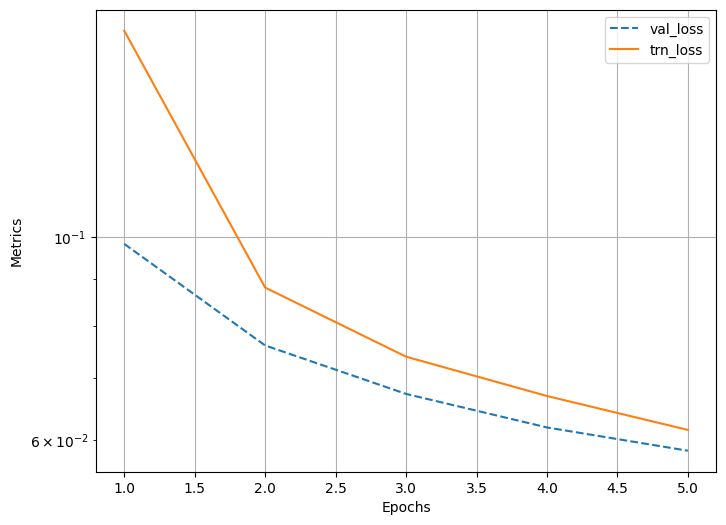

In [7]:
log.plot_epochs(log=True)

In [8]:
save_path = 'my_CNN_autoencoder_5_epochs.pth'
torch.save(model.state_dict(), save_path)

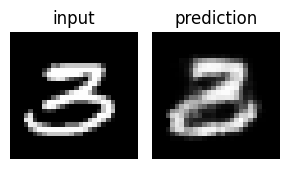

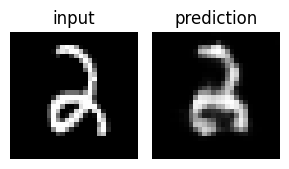

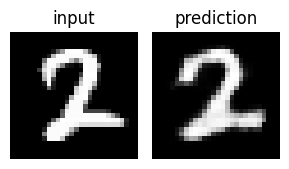

In [9]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

Now , we will make groups for similar images. For this purpose, we will use t-SNE and reduce the 64 dimensional bottleneck layer to 2 dimentional space.

In [10]:
latent_vectors = []
classes = []

In [11]:
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [12]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [14]:
clustered = tsne.fit_transform(latent_vectors)

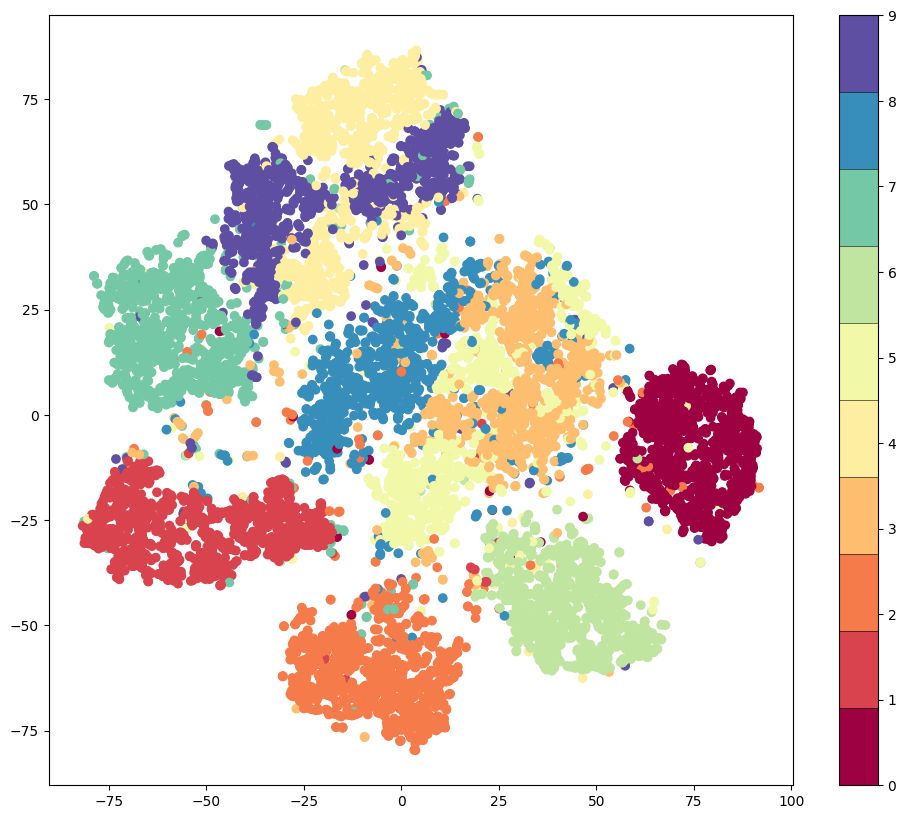

In [15]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

## Limitation of autoencoders for generating images

from book : 

''...
So far, we have seen a scenario where we can group similar images into clusters.
Furthermore, we have learned that when we take embeddings of images that fall in a
given cluster, we can re-construct (decode) them. However, what if an embedding (a
latent vector) falls in between two clusters? There is no guarantee that we would
generate realistic images.
...''

In [16]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)

In [17]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu, sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100) + mu)

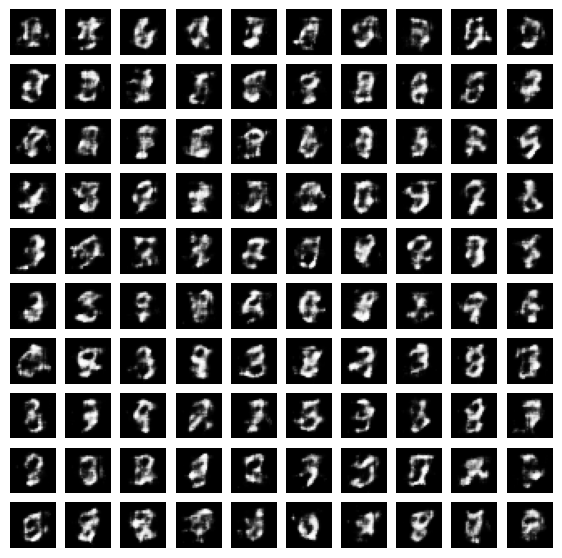

In [18]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))

##### This is why we need the variational autoencoders (VAE)... Check VAE_NIST notebook...